In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

In [2]:
if True:
    # load data from csv files
    df = pd.DataFrame()
    for root, dirs, files in os.walk("./data"):
        for name in files:
            file_name = os.path.join(root, name)
            if 'pools_ge250_loans' in file_name:
                if len(df) > 0:
                    df = pd.concat([df,pd.read_csv(file_name)])
                else:
                    df = pd.read_csv(file_name)        

    model_name = 'nn-ppm-from-csv.h5' # for saving a model later

else:
    dill.load_session('notebook_env_all_3_dfs.db')

    print('Loaded data as is:')
    print('attr_df.shape   = ', attr_df.shape)
    print('geo_df.shape    = ', geo_df.shape)
    print('seller_df.shape = ', seller_df.shape)

    nloans = 250
    attr_df = attr_df[attr_df['cnloans']>=nloans]

    print('Data size after filtering for >= 250 loans:')
    print(f'attr_df.shape = {attr_df.shape}')

    geo_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(attr_df,geo_df,on=['cusip','asofdate'],how='left')

    seller_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(df,seller_df,on=['cusip','asofdate'],how='left')

    df.fillna(0,inplace=True)

    model_name = 'nn-ppm-dill-data.h5' # for saving a model later

df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

#df['asofdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))

# df['SMM'] = df['SMM']/100.0

print('df.shape = ', df.shape)

df.shape =  (594533, 111)


In [3]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594533 entries, 0 to 29999
Data columns (total 111 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   poolno              594533 non-null  object 
 1   asofdate            594533 non-null  int64  
 2   cusip               594533 non-null  object 
 3   spread              594533 non-null  float64
 4   SMM                 594533 non-null  float64
 5   DayCount            594533 non-null  float64
 6   OBal                594533 non-null  float64
 7   CBal                594533 non-null  float64
 8   factor              594533 non-null  float64
 9   Coupon              594533 non-null  float64
 10  Wac                 594533 non-null  float64
 11  Wam                 594533 non-null  float64
 12  Age                 594533 non-null  float64
 13  aols                594533 non-null  float64
 14  waols               594533 non-null  float64
 15  ONLoans             594533 non-nul

In [4]:
df.head()

poolno  asofdate      cusip  spread     SMM  DayCount         OBal  \
0  932473    201002  31412Q6J3    -2.7  0.1184      19.0  503049960.0   
1  932473    201003  31412Q6J3    -5.7  0.2017      23.0  503049960.0   
2  932473    201004  31412Q6J3    -2.6  0.0811      22.0  503049960.0   
3  932473    201005  31412Q6J3    -7.9  0.3476      20.0  503049960.0   
4  932473    201006  31412Q6J3    -4.0  0.6786      22.0  503049960.0   

           CBal     factor  Coupon  ...  SellerPct_NATIONST  SellerPct_NRESM  \
0  5.012071e+08  99.633659     4.5  ...                 0.0              0.0   
1  4.995732e+08  99.308870     4.5  ...                 0.0              0.0   
2  4.985434e+08  99.104151     4.5  ...                 0.0              0.0   
3  4.961853e+08  98.635394     4.5  ...                 0.0              0.0   
4  4.921947e+08  97.842115     4.5  ...                 0.0              0.0   

   SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  SellerPct_REG  \
0               0.0               0.0              0.0            0.0   
1               0.0               0.0              0.0            0.0   
2               0.0               0.0              0.0            0.0   
3               0.0               0.0              0.0            0.0   
4               0.0               0.0              0.0            0.0   

   SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  Seasonality  
0             0.0               0.0             0.0            2  
1             0.0               0.0             0.0            3  
2             0.0               0.0             0.0            4  
3             0.0               0.0             0.0            5  
4             0.0               0.0             0.0            6  

[5 rows x 111 columns]

In [5]:
model_columns = ['asofdate',
                 'SMM',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                 'Seasonality',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM']

dfm = df[model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.head()

dfm.shape = (594533, 103)


asofdate     SMM  spread  DayCount     factor    Wac    Wam  Age      aols  \
0    201002  0.1184    -2.7      19.0  99.633659  4.953  355.0  2.0  257940.0   
1    201003  0.2017    -5.7      23.0  99.308870  4.953  354.0  3.0  257971.0   
2    201004  0.0811    -2.6      22.0  99.104151  4.953  353.0  4.0  257930.0   
3    201005  0.3476    -7.9      20.0  98.635394  4.954  352.0  5.0  257972.0   
4    201006  0.6786    -4.0      22.0  97.842115  4.953  350.0  6.0  257650.0   

      waols  ...  SellerPct_NCM  SellerPct_NATIONST  SellerPct_NRESM  \
0  257940.0  ...            0.0                 0.0              0.0   
1  257971.0  ...            0.0                 0.0              0.0   
2  257930.0  ...            0.0                 0.0              0.0   
3  257972.0  ...            0.0                 0.0              0.0   
4  257650.0  ...            0.0                 0.0              0.0   

   SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  SellerPct_REG  \
0               0.0               0.0              0.0            0.0   
1               0.0               0.0              0.0            0.0   
2               0.0               0.0              0.0            0.0   
3               0.0               0.0              0.0            0.0   
4               0.0               0.0              0.0            0.0   

   SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  
0             0.0               0.0             0.0  
1             0.0               0.0             0.0  
2             0.0               0.0             0.0  
3             0.0               0.0             0.0  
4             0.0               0.0             0.0  

[5 rows x 103 columns]

In [6]:
dummies = pd.get_dummies(dfm['Seasonality'],drop_first=True)
dfm = dfm.drop('Seasonality',axis=1)
dfm = pd.concat([dfm,dummies],axis=1)

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (594533, 113)


In [7]:
# define train/test split
# from sklearn.model_selection import train_test_split

# X = dfm.drop(['SMM','asofdate'],axis=1)
# y = dfm['SMM'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

dfm_train = dfm[dfm['asofdate'] <  201701]
dfm_test  = dfm[dfm['asofdate'] >= 201701]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print('\n')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (328786, 111)
y_train.shape = (328786,)


X_test.shape  = (265747, 111)
y_test.shape  = (265747,)


In [8]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [10]:
# import kerastuner as kt 

In [11]:
# def model_builder(hp):

#     model = Sequential()
    
#     #input layer / first hidden layer

#     first_layer_neurons      = hp.Int('layer_1_units', min_value=32, max_value = 1024, step = 32)
#     first_layer_dropout_rate = hp.Float('layer_1_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(first_layer_neurons, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(first_layer_dropout_rate))

#     # 2nd layer
#     second_layer_neurons      = hp.Int('layer_2_units', min_value=128, max_value = 512, step = 32)
#     second_layer_dropout_rate = hp.Float('layer_2_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(second_layer_neurons, activation='relu'))
#     model.add(Dropout(second_layer_dropout_rate))

#     # 3rd layer
#     third_layer_neurons      = hp.Int('layer_3_units', min_value=64, max_value = 256, step = 32)
#     third_layer_dropout_rate = hp.Float('layer_3_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(third_layer_neurons, activation='relu'))
#     model.add(Dropout(third_layer_dropout_rate))

#     # 4th layer
#     forth_layer_neurons      = hp.Int('layer_4_units', min_value=32, max_value = 128, step = 32)
#     forth_layer_dropout_rate = hp.Float('layer_4_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(forth_layer_neurons, activation='relu'))
#     model.add(Dropout(forth_layer_dropout_rate))

#     #output layer
#     model.add(Dense(1, activation='relu')) # relu activation is perfect here, because SMM cannot be negative

#     model.compile(optimizer='adam', loss='mse')
#     #model.compile(optimizer='rmsprop', loss='mse')    

#     return model

In [12]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_loss',
#                      max_epochs=10,
#                      hyperband_iterations=2,
#                      directory=os.path.normpath('C:/'),
#                      project_name='nn_ppm_model-' + dt.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))

In [13]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1024,
#              epochs=10)

In [14]:
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [15]:
# model = tuner.hypermodel.build(best_hps)

In [16]:
# model.summary()

In [17]:
# tuner.results_summary()

In [18]:
model = Sequential()

#input layer / first hidden layer
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

# hidden layers
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dropout(0.5))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x
#model.add(Dense(1)) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer='rmsprop', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=1024,
          epochs=300)

Train on 328786 samples, validate on 265747 samples
Epoch 1/300
328786/328786 [==============================] - 8s 23us/sample - loss: 0.7398 - val_loss: 0.3209
Epoch 2/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4921 - val_loss: 0.3036
Epoch 3/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4486 - val_loss: 0.3003
Epoch 4/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4271 - val_loss: 0.3054
Epoch 5/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4132 - val_loss: 0.3085
Epoch 6/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4041 - val_loss: 0.3011
Epoch 7/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3972 - val_loss: 0.2950
Epoch 8/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3909 - val_loss: 0.3022
Epoch 9/300
328786/328786 [==============================] - 7s 22us

328786/328786 [==============================] - 7s 22us/sample - loss: 0.3283 - val_loss: 0.2998
Epoch 75/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3269 - val_loss: 0.3018
Epoch 76/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3241 - val_loss: 0.2944
Epoch 77/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3259 - val_loss: 0.3025
Epoch 78/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3267 - val_loss: 0.2994
Epoch 79/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3247 - val_loss: 0.2920
Epoch 80/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3253 - val_loss: 0.2963
Epoch 81/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3272 - val_loss: 0.2994
Epoch 82/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3248 - val_loss: 0.2890
Epoch 83/300
3

328786/328786 [==============================] - 7s 21us/sample - loss: 0.3108 - val_loss: 0.2936
Epoch 148/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3107 - val_loss: 0.3004
Epoch 149/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3116 - val_loss: 0.2951
Epoch 150/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3117 - val_loss: 0.2929
Epoch 151/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3112 - val_loss: 0.2930
Epoch 152/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3116 - val_loss: 0.2963
Epoch 153/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3115 - val_loss: 0.2942
Epoch 154/300
328786/328786 [==============================] - 7s 23us/sample - loss: 0.3101 - val_loss: 0.2925
Epoch 155/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3116 - val_loss: 0.2942
Epoch 

328786/328786 [==============================] - 7s 22us/sample - loss: 0.3030 - val_loss: 0.2961
Epoch 221/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3038 - val_loss: 0.3000
Epoch 222/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3037 - val_loss: 0.2990
Epoch 223/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3057 - val_loss: 0.2963
Epoch 224/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3071 - val_loss: 0.2925
Epoch 225/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3014 - val_loss: 0.2927
Epoch 226/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3036 - val_loss: 0.2885
Epoch 227/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3030 - val_loss: 0.2974
Epoch 228/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3028 - val_loss: 0.2952
Epoch 

328786/328786 [==============================] - 7s 21us/sample - loss: 0.2978 - val_loss: 0.2928
Epoch 294/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2988 - val_loss: 0.2913
Epoch 295/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2992 - val_loss: 0.2945
Epoch 296/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2978 - val_loss: 0.2915
Epoch 297/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2966 - val_loss: 0.2923
Epoch 298/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.2982 - val_loss: 0.2909
Epoch 299/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2973 - val_loss: 0.2913
Epoch 300/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.2988 - val_loss: 0.2937


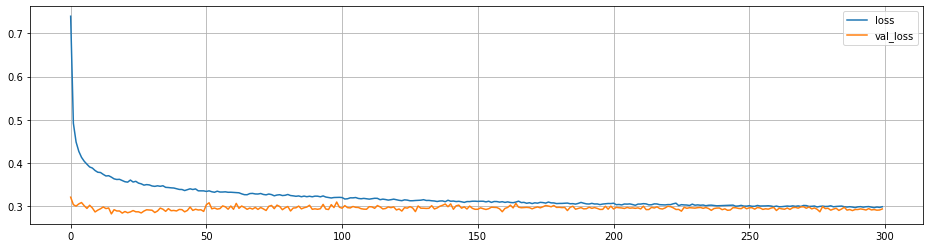

In [20]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

In [21]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.3935
(test set) mean sq root sq error     = 0.5419
(test set) explained variance score  = 0.3969


(train set) mean absolute error      = 0.3793
(train set) mean sq root sq error    = 0.5257
(train set) explained variance score = 0.7419


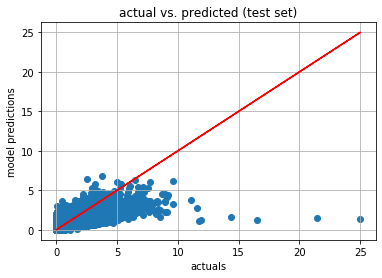

In [22]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

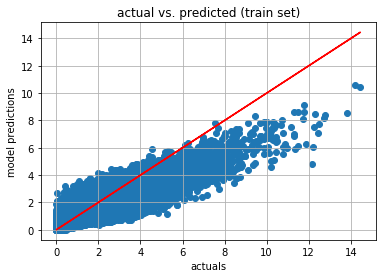

In [23]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

In [24]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
else:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop('SMM',axis=1)))

In [25]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

In [26]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)

    fig = plt.figure(figsize=fsize)
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

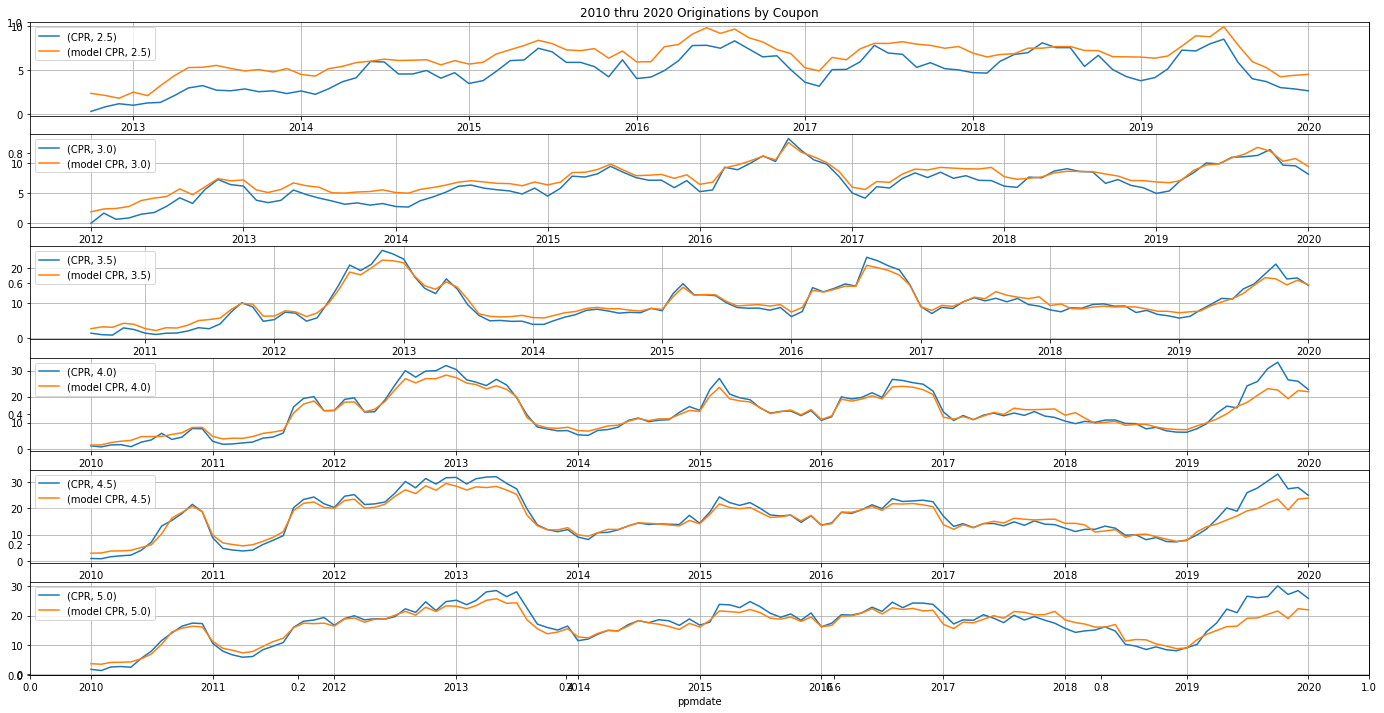

In [27]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

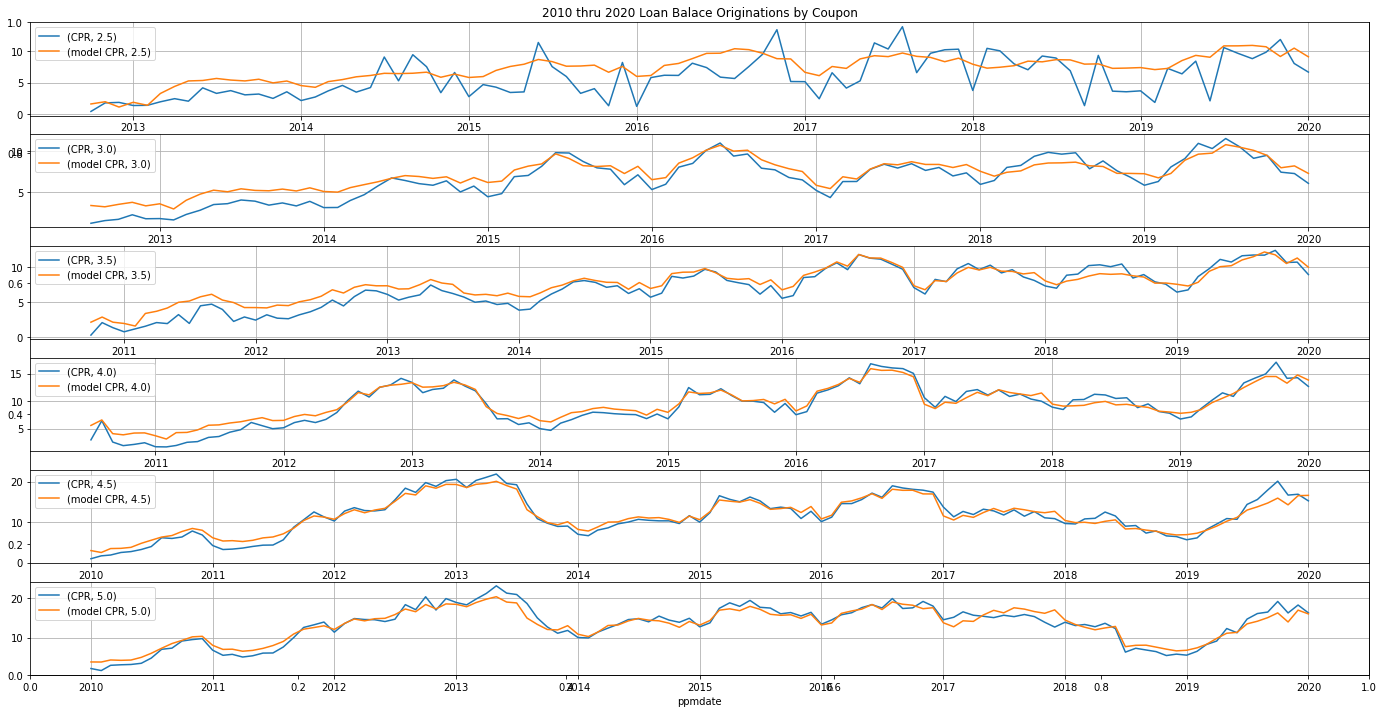

In [28]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

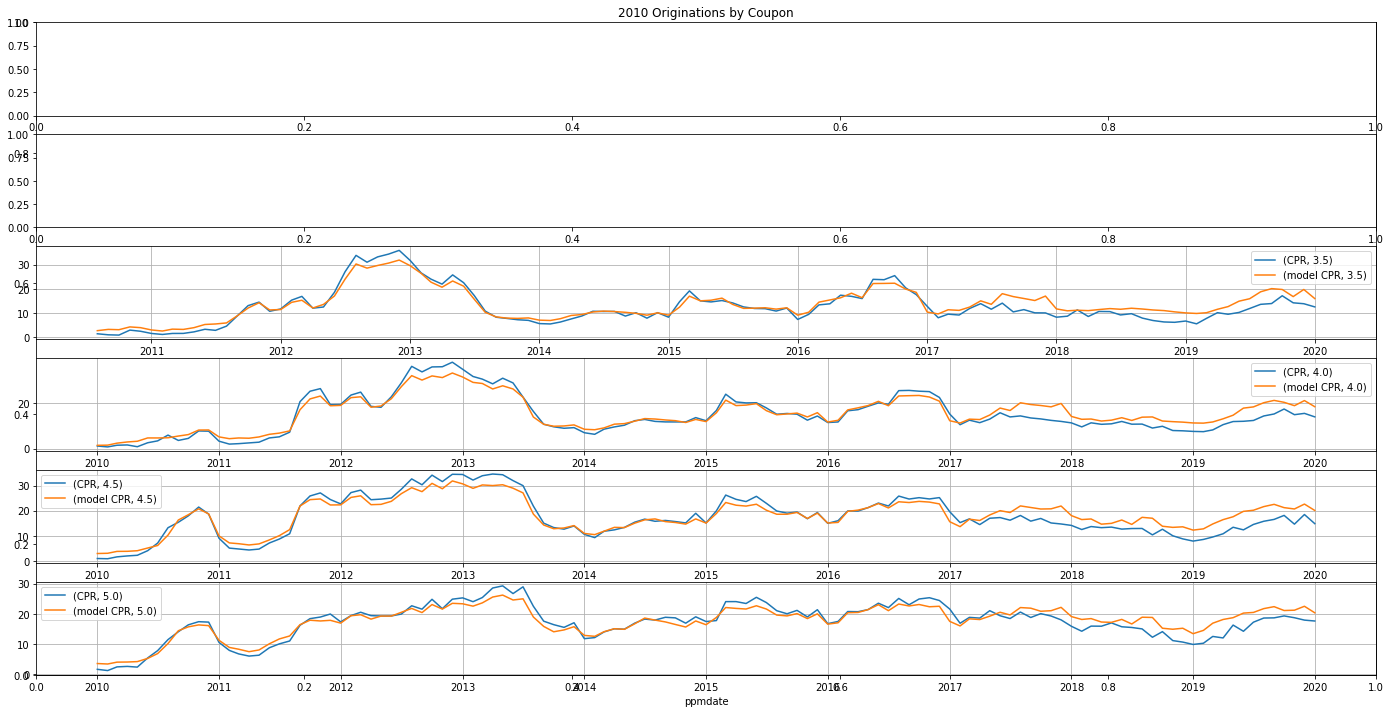

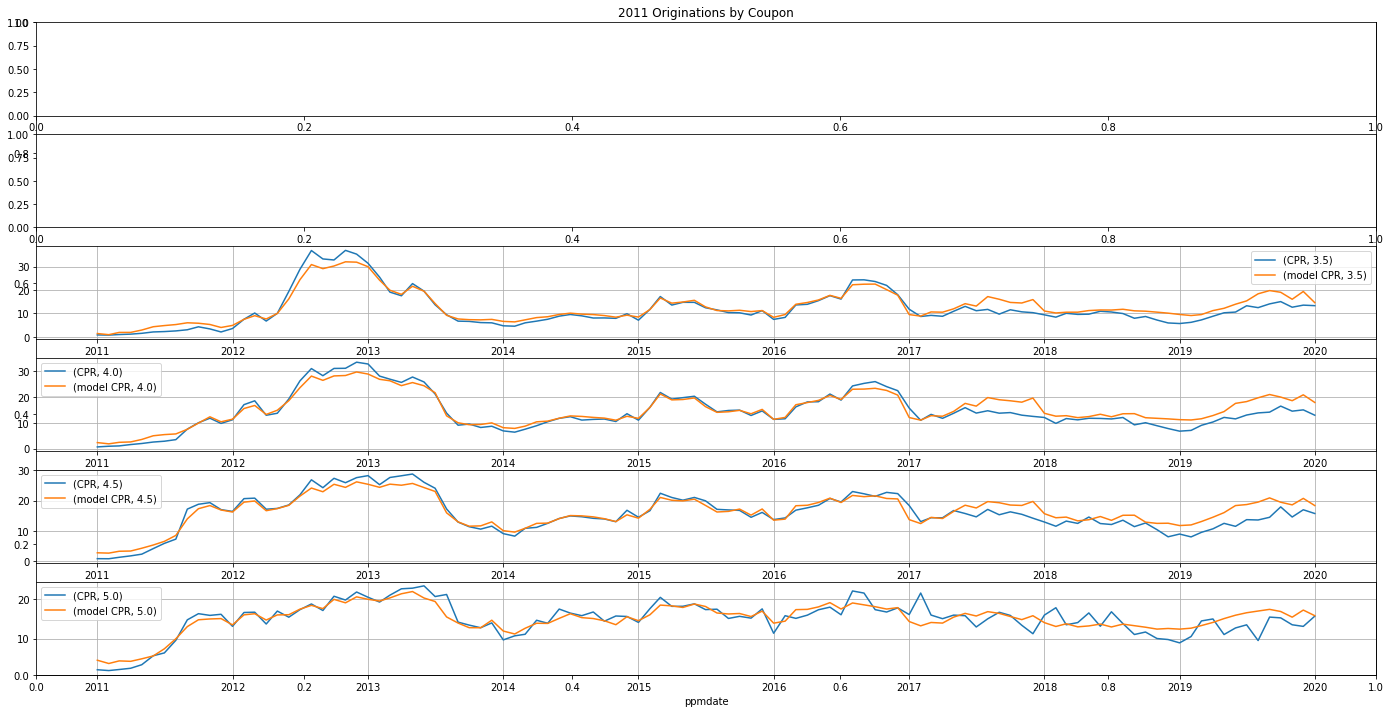

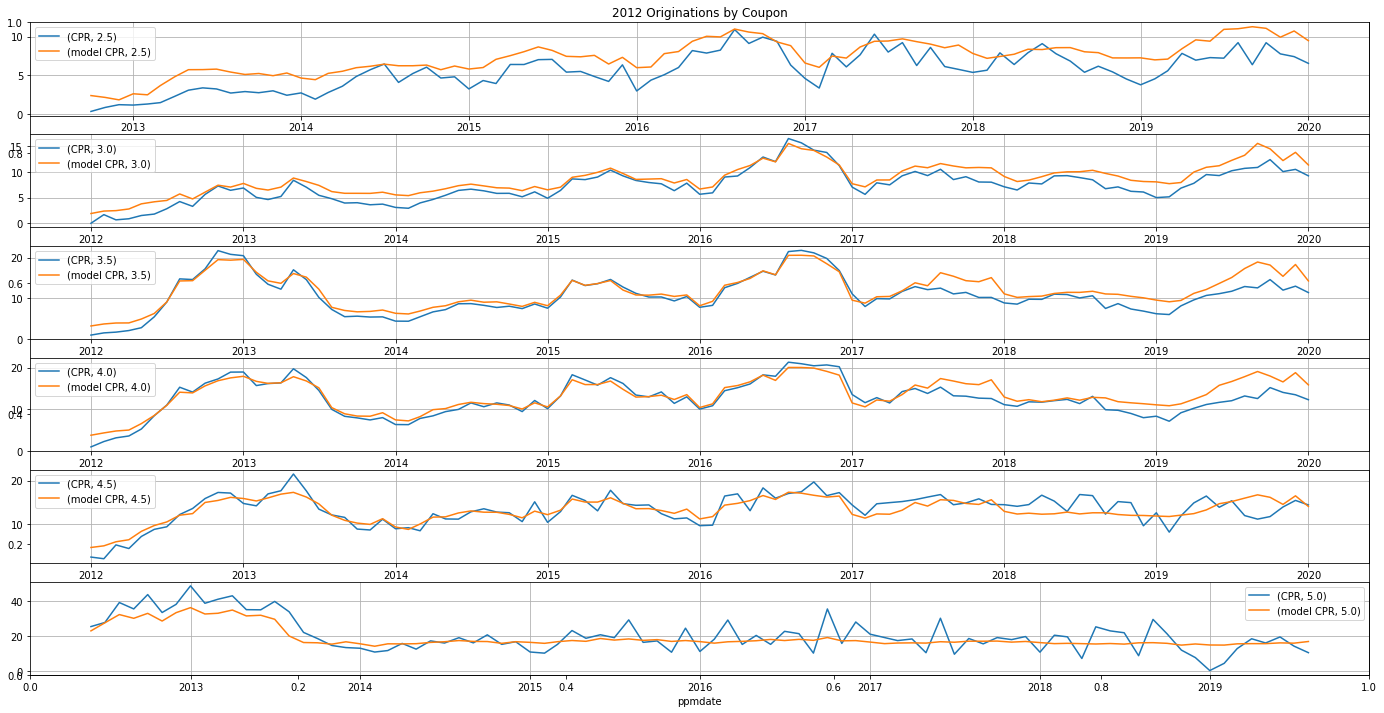

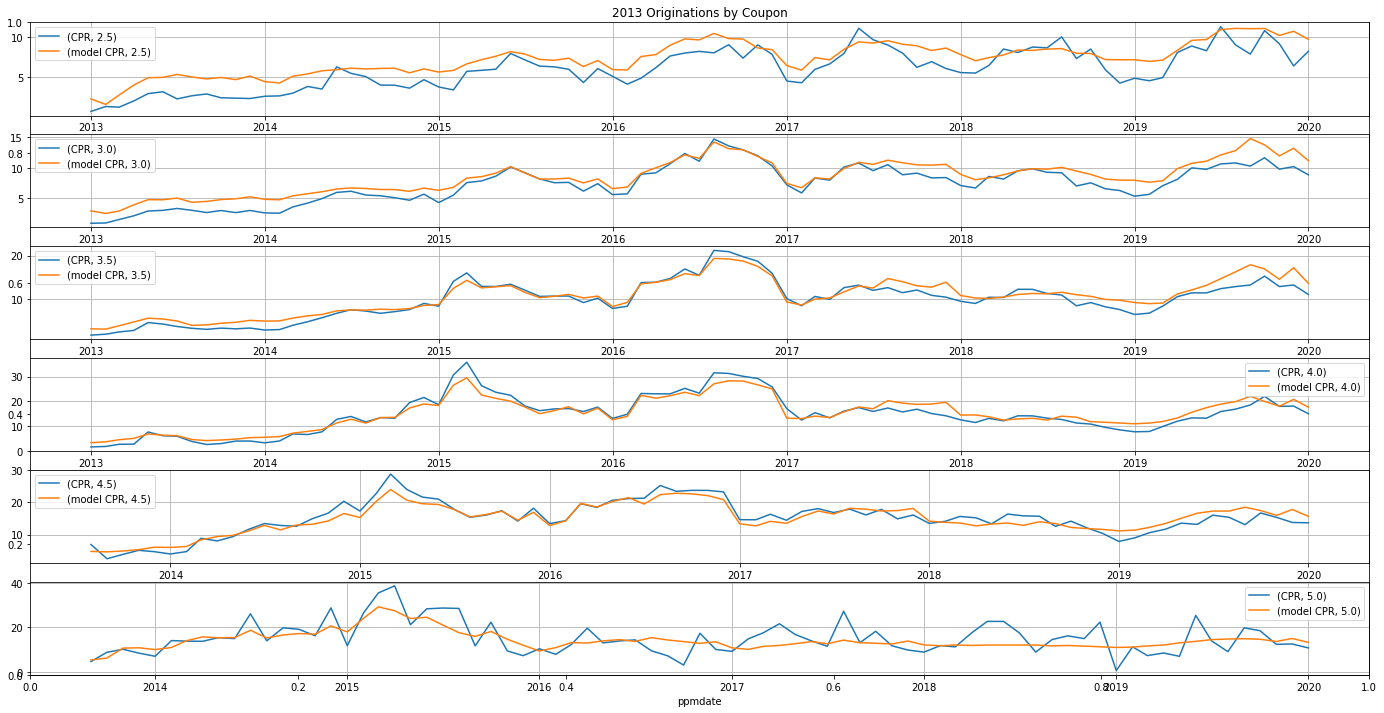

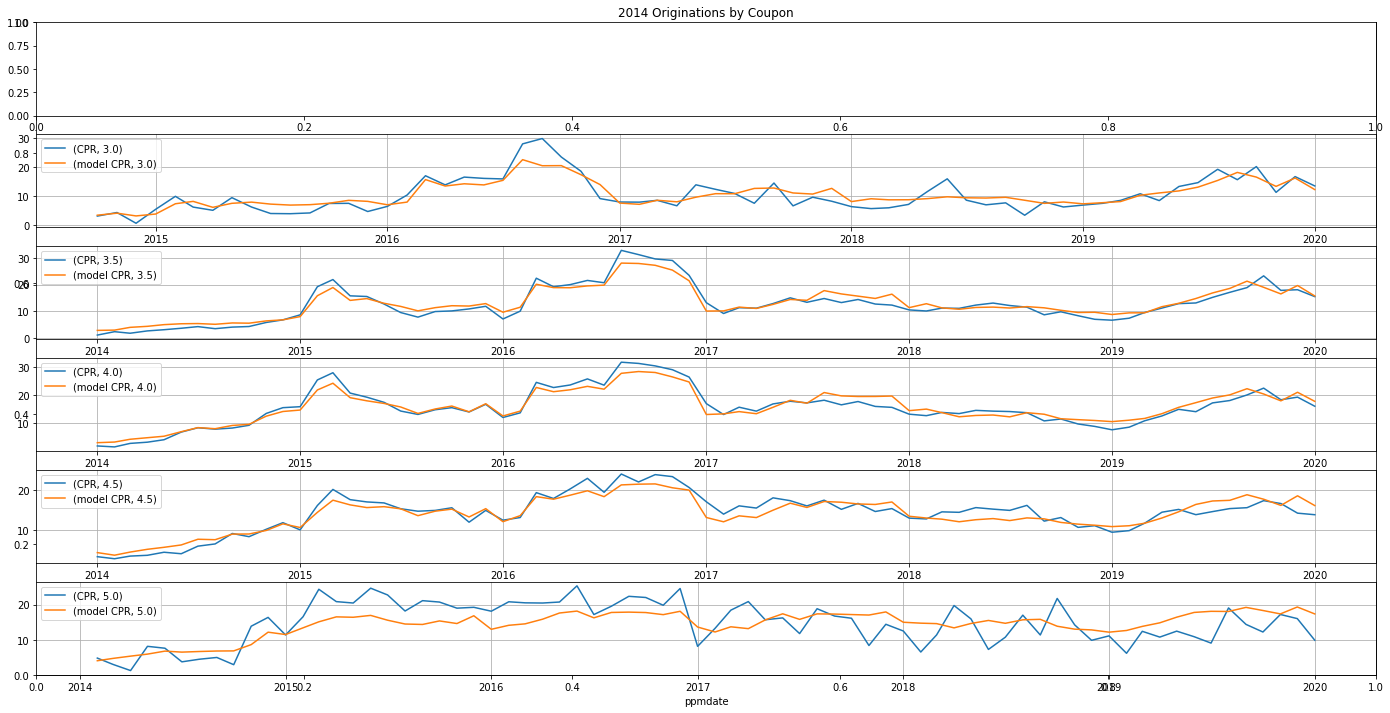

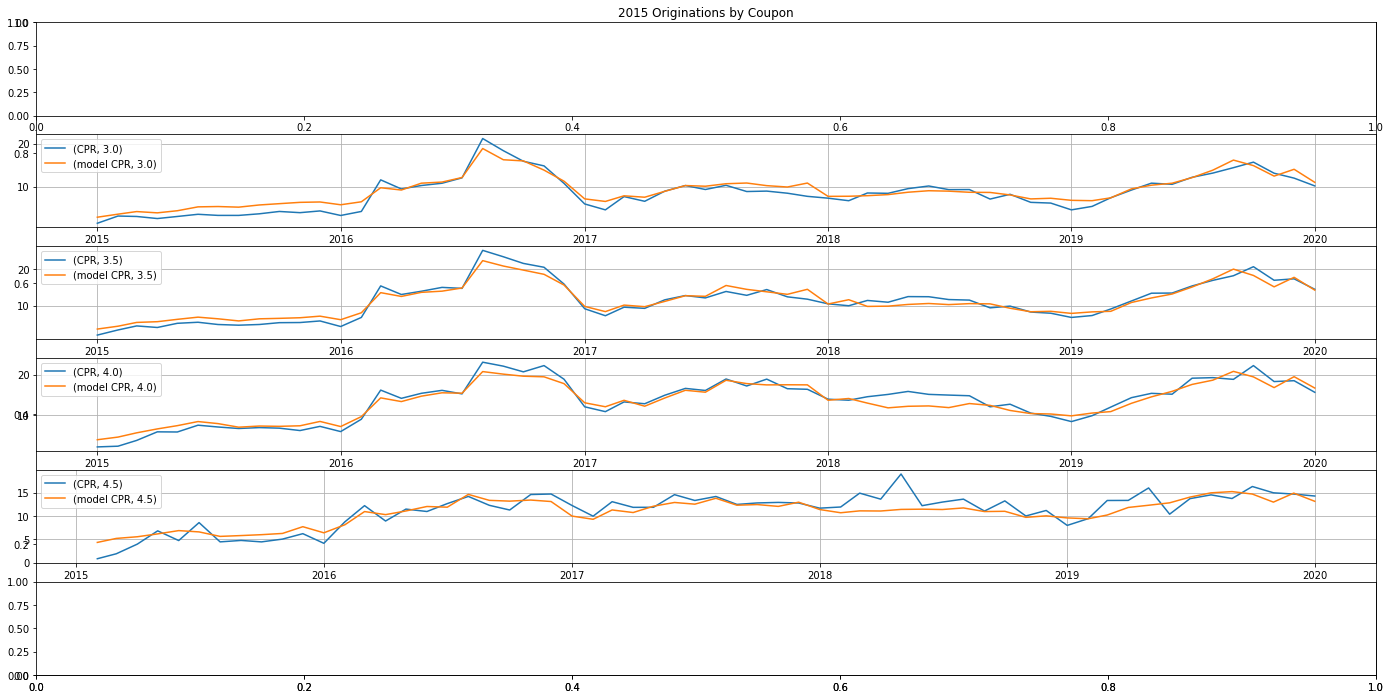

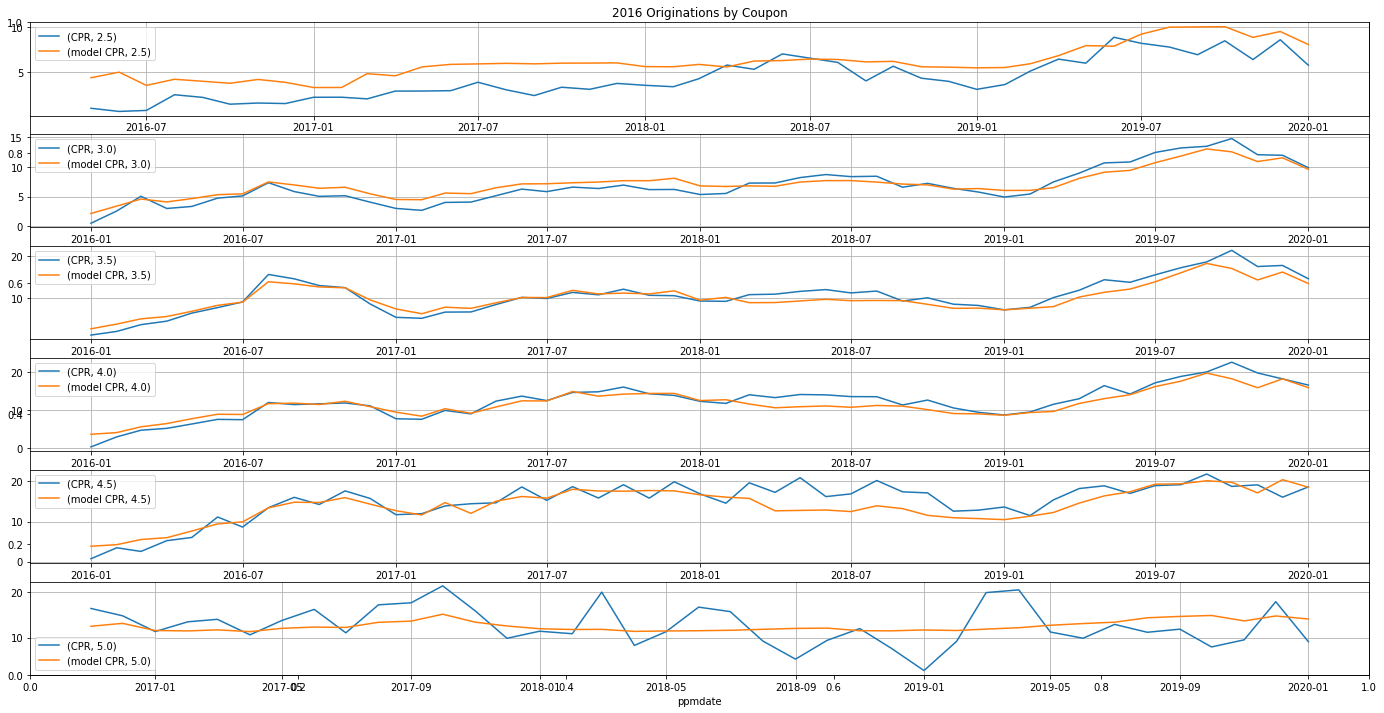

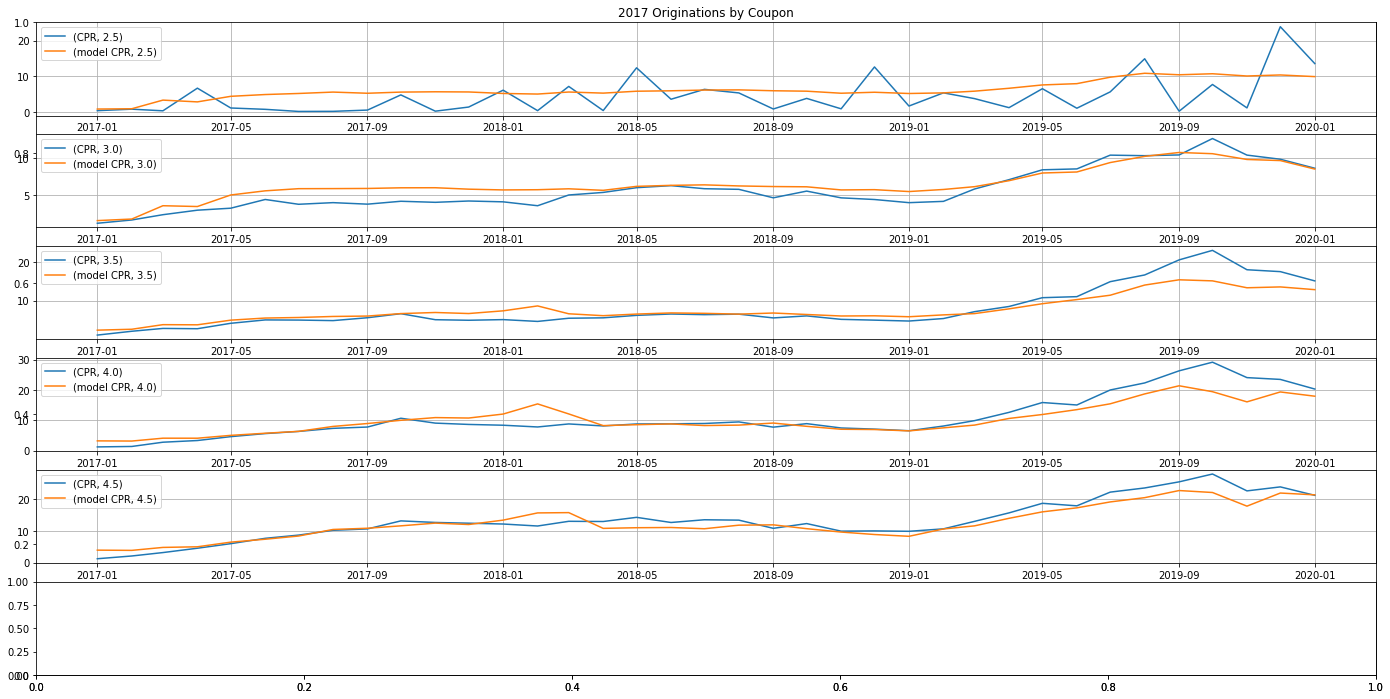

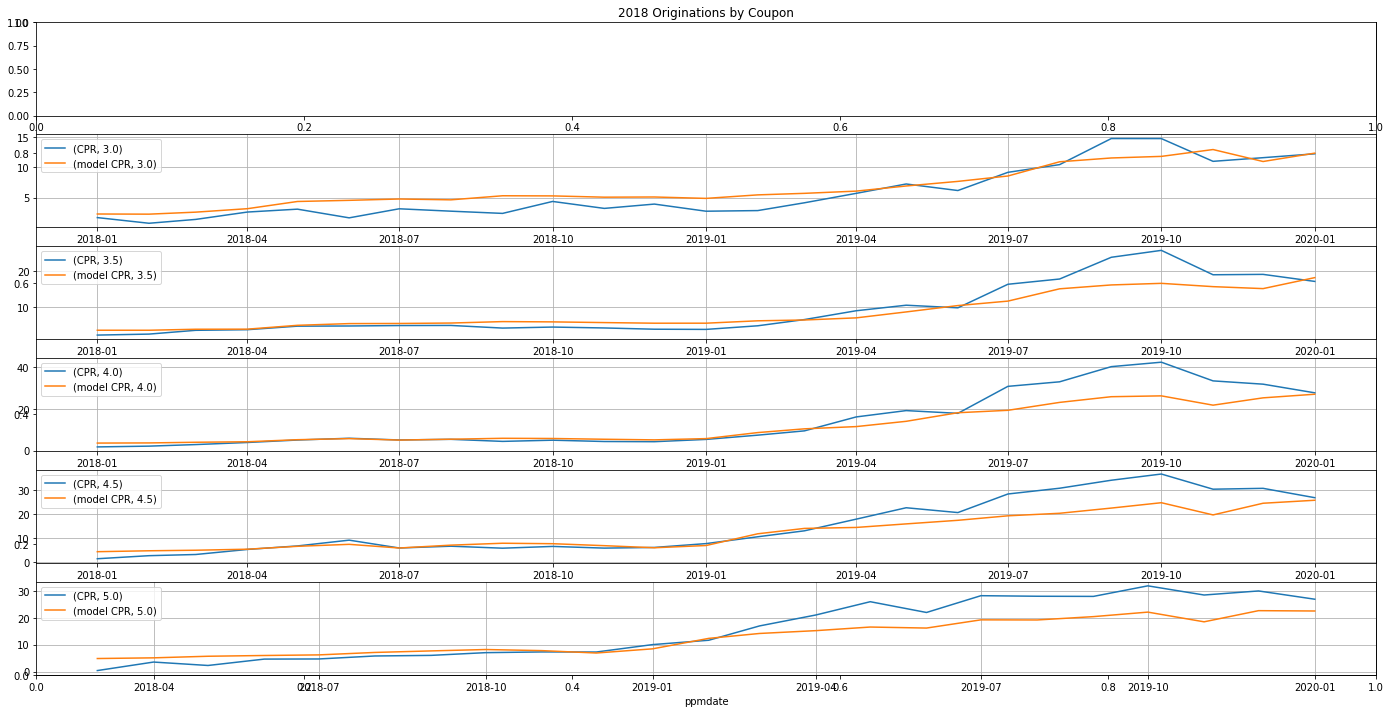

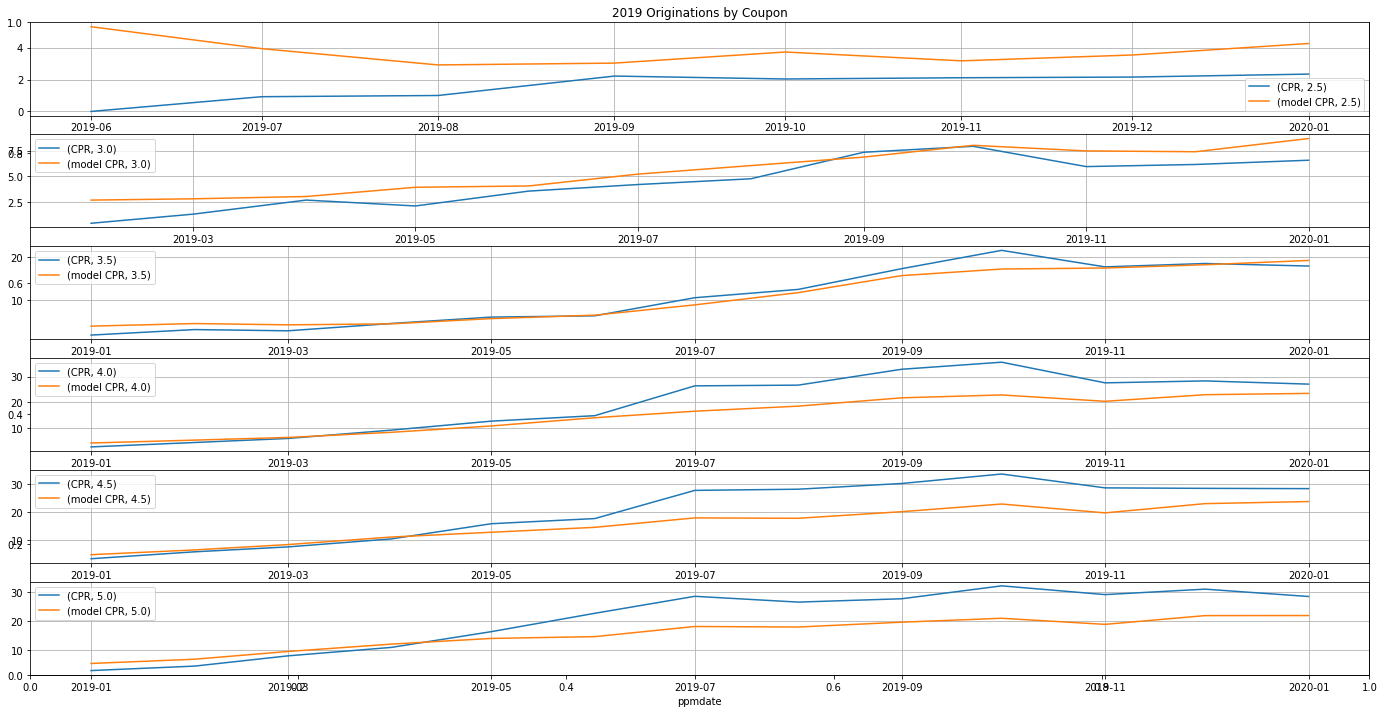

In [29]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:

    valReport(df[df['Vintage'] == vintage],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

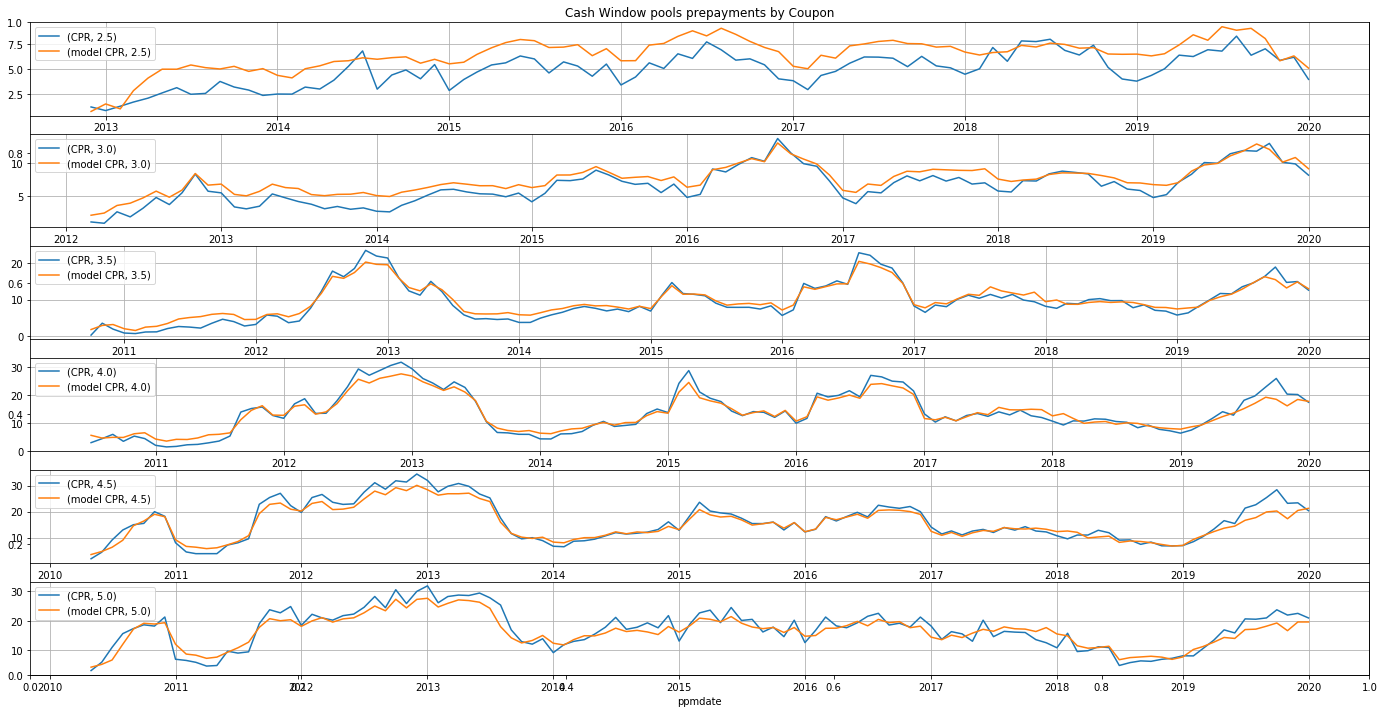

In [30]:
valReport(df[(df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

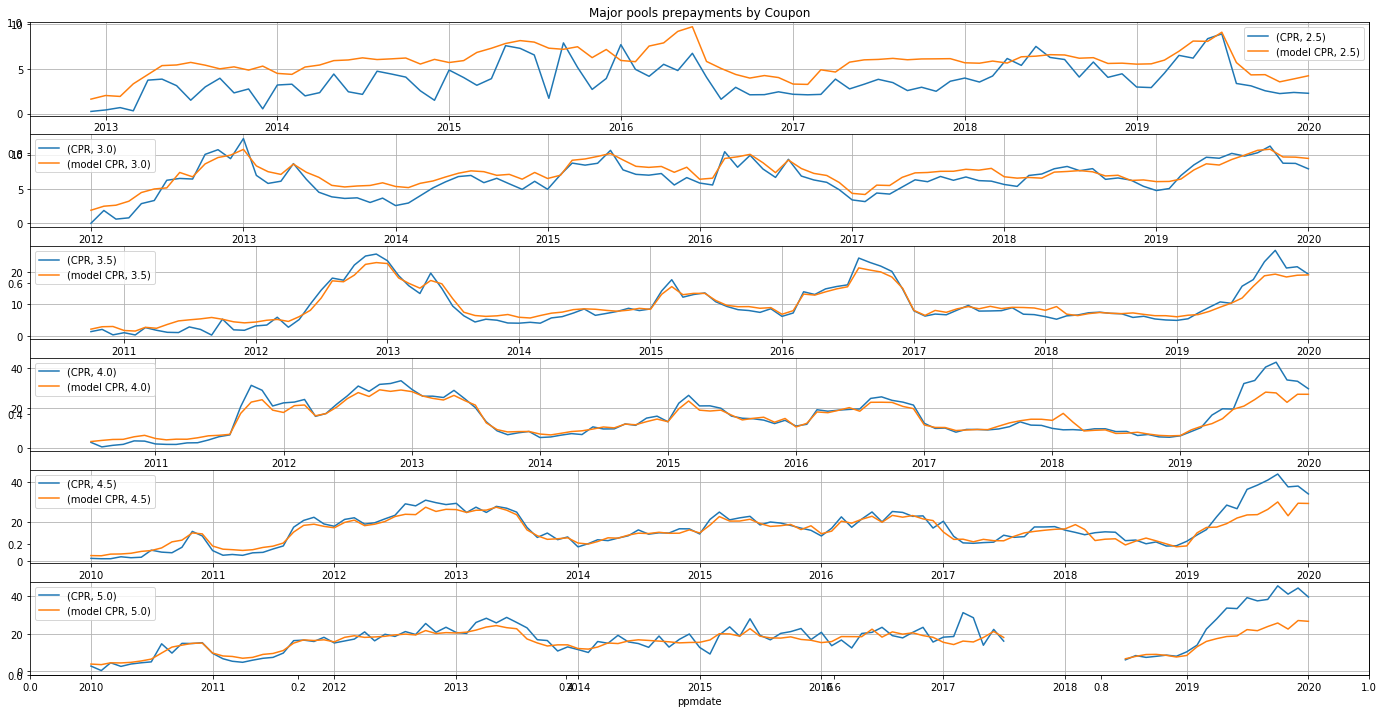

In [31]:
valReport(df[(df['%Majors'] == 100) & (df['Vintage'] > 2009)],graphTitle='Major pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

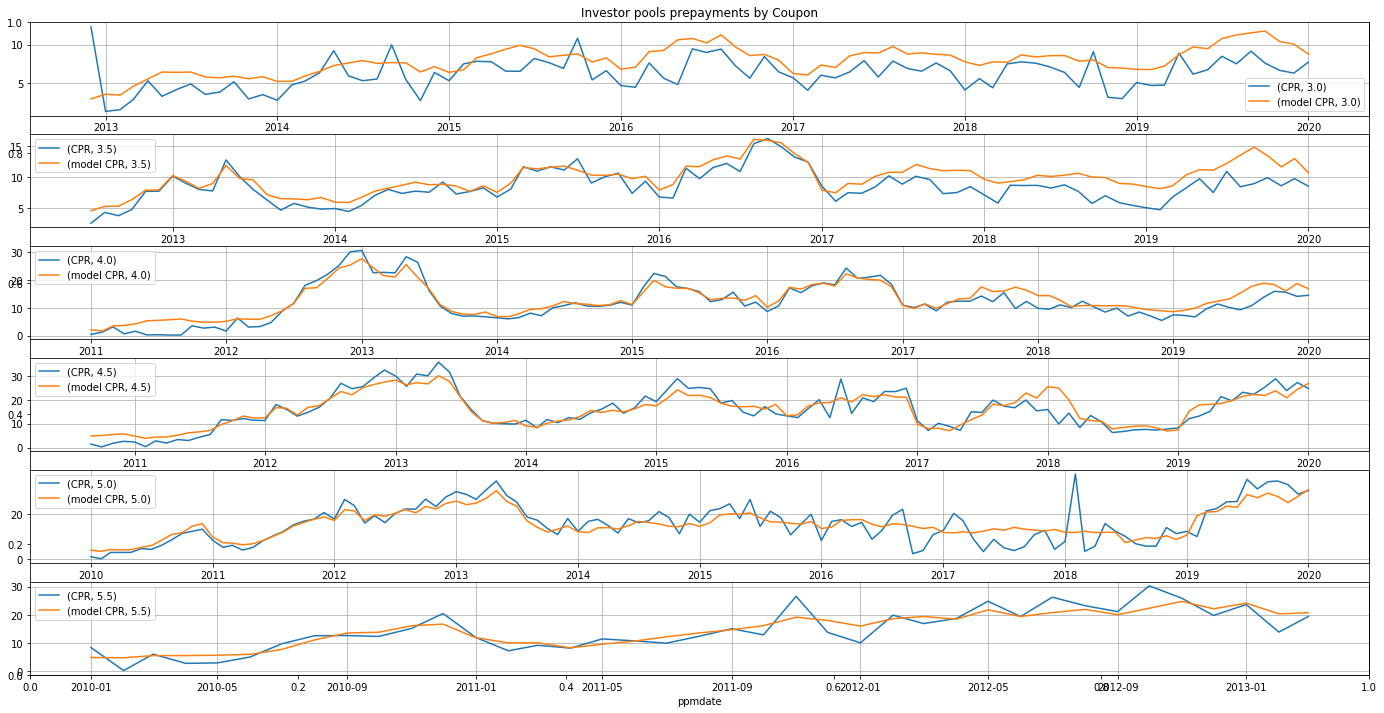

In [32]:
valReport(df[(df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

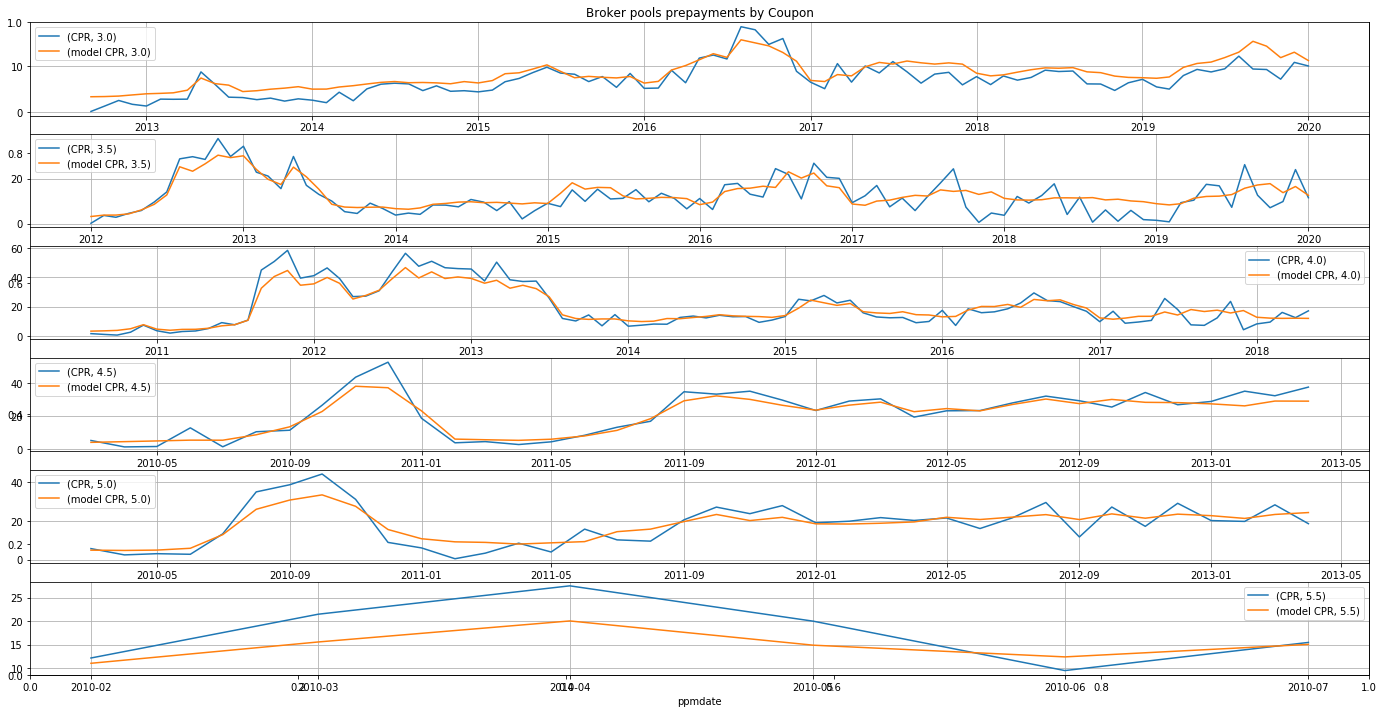

In [33]:
valReport(df[(df['PctChannel_Broker'] > 99) & (df['Vintage'] > 2009)],graphTitle='Broker pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

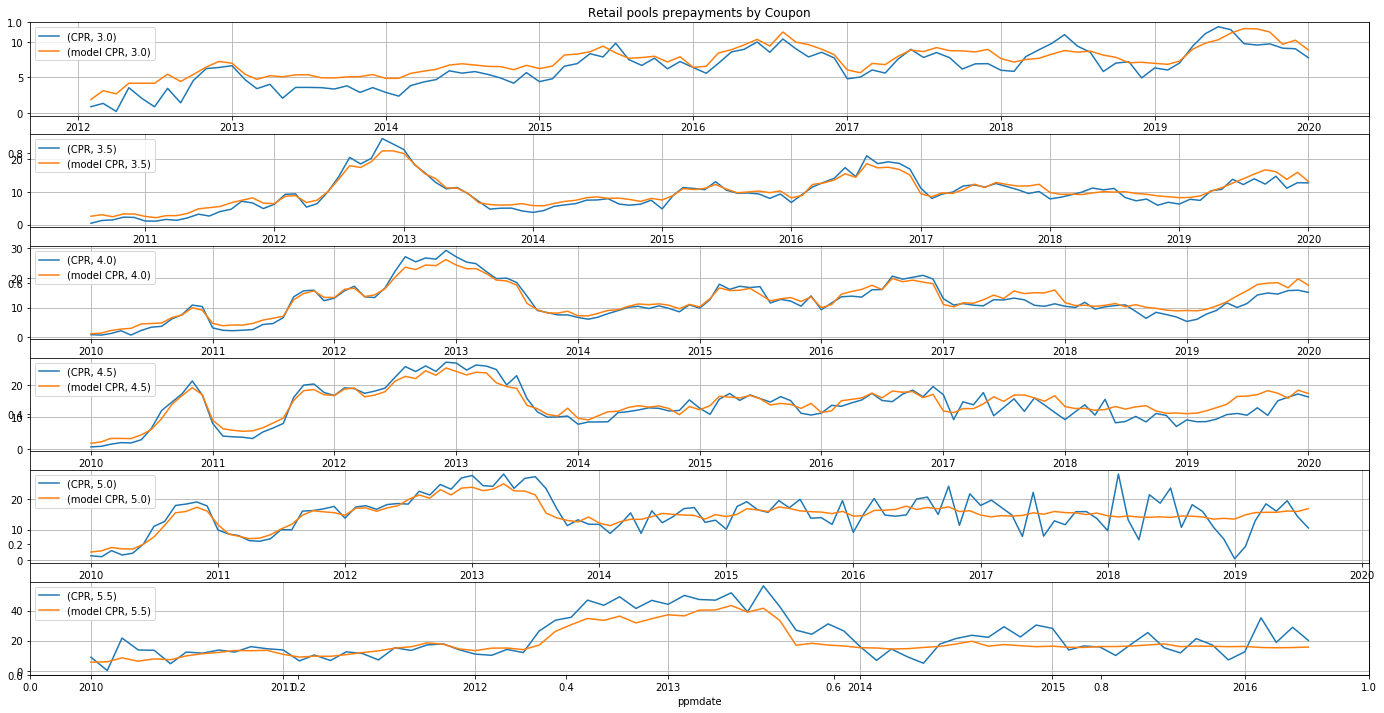

In [34]:
valReport(df[(df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

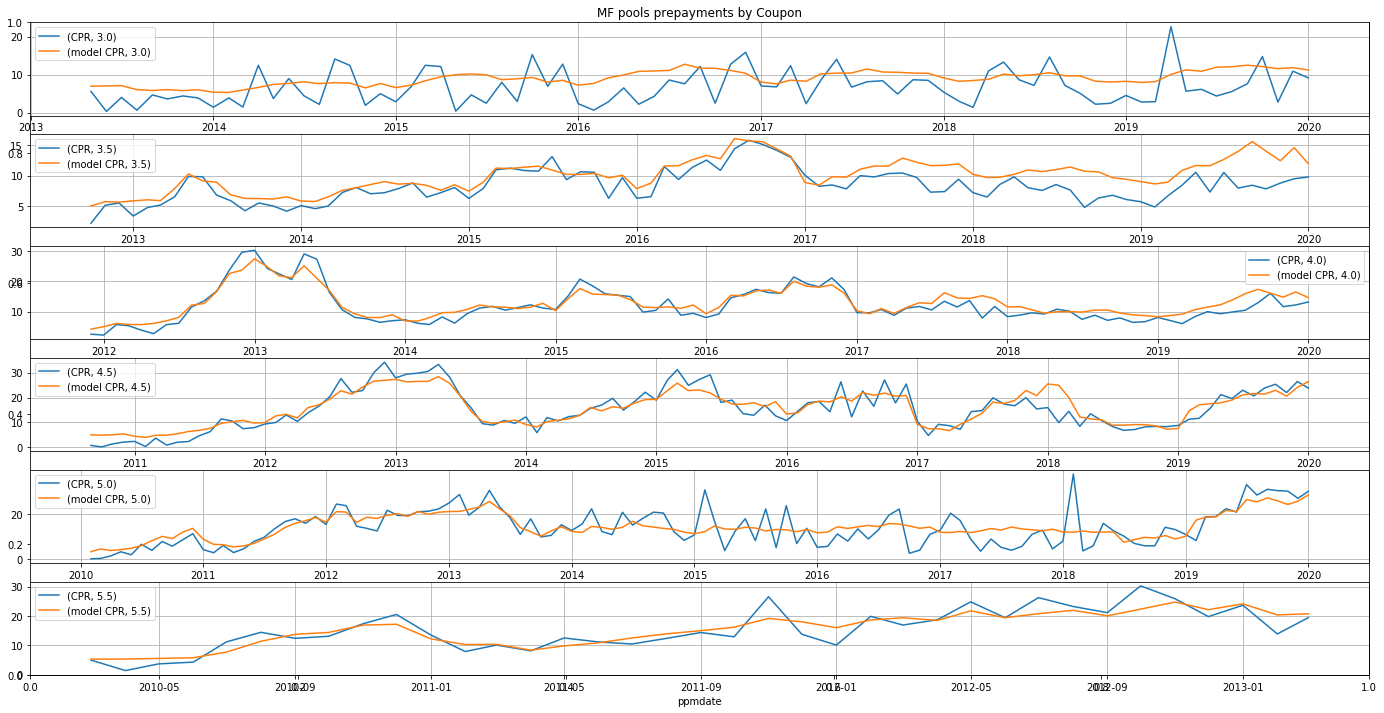

In [35]:
valReport(df[(df['PropUnitsPct_2-4'] > 25) & (df['Vintage'] > 2009)],graphTitle='MF pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

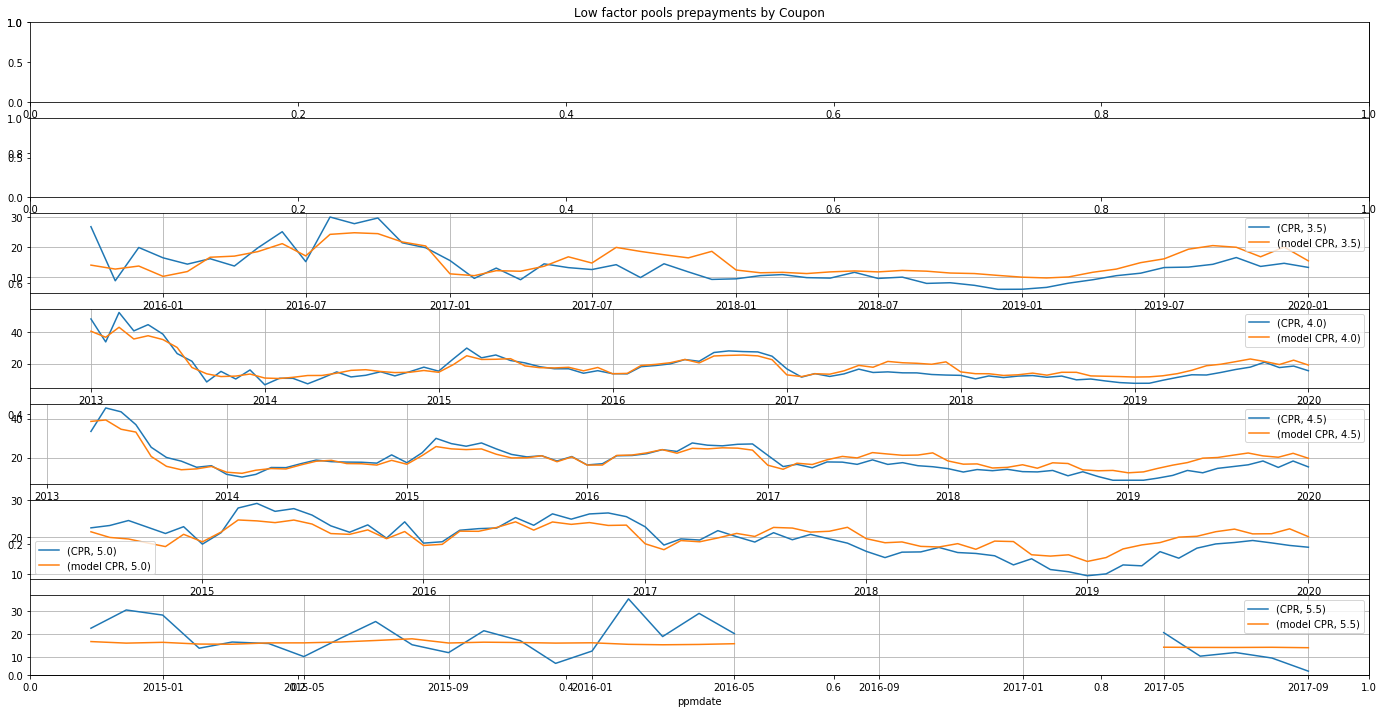

In [36]:
valReport(df[(df['factor'] < 30) & (df['Vintage'] > 2009)],graphTitle='Low factor pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5.5)

In [37]:
# 'DayCount','factor',
# 'Wac','Wam','Age','aols','waols','CSato',
# 'oltv','cltv','ocltv','ccltv',
# 'fico',
# '%CashWindow','%Majors',
# 'PurpPct_purchase','PurpPct_refi',
# 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
# 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
# 'Seasonality',

In [38]:
from tensorflow.keras.models import load_model

In [39]:
model_name

'nn-ppm-from-csv.h5'

In [42]:
model.save(model_name)

In [41]:
# later_model = load_model('nn-ppm-dill-data.h5')